In [1]:
import geemap
import ee

import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point

import json

import os

In [2]:
ee.Authenticate()
ee.Initialize()


Successfully saved authorization token.


# Get shapefiles into Earth Engine

PROJCS["Sphere_ARC_INFO_Lambert_Azimuthal_Equal_Area",GEOGCS["GCS_Sphere_ARC_INFO",DATUM["D_Sphere_ARC_INFO",SPHEROID["Sphere_ARC_INFO",6370997,0]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",90],PARAMETER["longitude_of_center",180],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


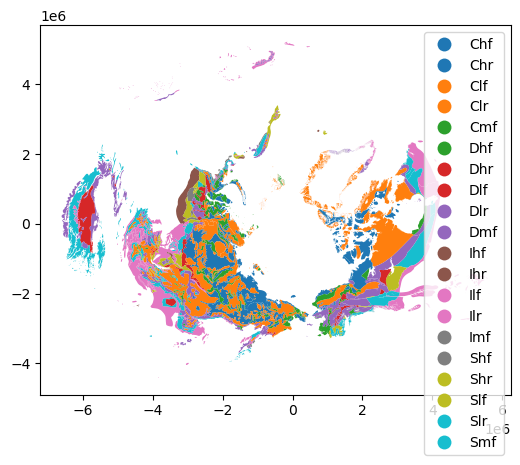

In [90]:
permafrost = gpd.read_file("../arctic-data/permaice.shp")

pf_filtered = permafrost.dropna(subset=['EXTENT'])

pf_filtered.plot(column='COMBO', legend=True)
print(pf_filtered.crs)

In [91]:
alaska = geemap.ee_to_shp(
    ee.FeatureCollection('TIGER/2016/States').filter(ee.Filter.eq('NAME', 'Alaska')),
    filename='../arctic-data/alaska.shp'
)

Generating URL ...
Please wait ...
Data downloaded to /dartfs/rc/lab/V/VecchioJ/computational-arctic-workshop/arctic-data/alaska.shp


In [92]:
alaska = gpd.read_file("../arctic-data/alaska.shp").to_crs(pf_filtered.crs)
permafrost_clipped = pf_filtered.clip(alaska)

# Note this is EXTREMELY efficient. You'd have to map over individual geometries in Earth Engine 

<Axes: >

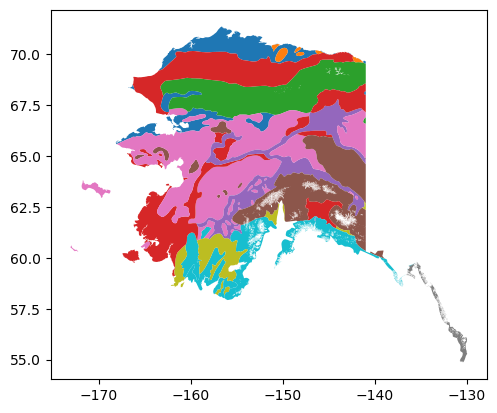

In [93]:
permafrost_clipped.to_crs('EPSG:4326').plot(column='COMBO')

In [94]:
permafrost_clipped.to_crs('EPSG:4326').to_file("../arctic-data/alaska_permafrost.shp")

## And now bring your newly clipped dataset into Earth Engine!

In [95]:
permafrost = geemap.shp_to_ee(
    os.path.join(os.path.dirname(os.getcwd()),"./arctic-data/alaska_permafrost.shp"),
     )

In [96]:
# This is commented out because it definitely works but the OG permafrost shapefile was super weird when it got projected to pseudo-Mercator
# permafrost_geoms = permafrost.map(lambda feature: feature.geometry())
# perma_clip = alaska.map(lambda feature: feature.intersection(permafrost_geoms, 1)); # 1 refers to the maxError argument


In [97]:
Map = geemap.Map()
Map.addLayer(permafrost, {}, 'permafrost')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

# Work with HydroSHED watershed boundaries

In [98]:
headwater_sheds = (
    ee.FeatureCollection("WWF/HydroSHEDS/v1/Basins/hybas_10")
    .filter(ee.Filter.equals(leftField = 'SUB_AREA', rightField = 'UP_AREA'))
    .filterBounds(ee.FeatureCollection('TIGER/2016/States').filter(ee.Filter.eq('NAME', 'Alaska')))
    )

In [99]:
Map.addLayer(headwater_sheds, {}, 'headwater sheds')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

## Define key functions

In [100]:
def createTimeBand(image):
  return image.addBands(image.metadata('system:time_start').divide(3.154e10));
  # // Scale is now in years
  # // in the linear regression output.

In [101]:
def annual_images(y):
    range_year = ee.Filter.calendarRange(y, y, 'year')
    range_month = ee.Filter.calendarRange(start_month, end_month, 'month')
    filtered_dataset = (index_collection
                        .filter(range_year)
                        .filter(range_month)
                        .map(createTimeBand)) # Needed for linear regression 
    # Combine the mean and standard deviation reducers.
    if analysis == 'mean':
      reducers = ee.Reducer.mean().combine(
        reducer2=ee.Reducer.stdDev(),
        sharedInputs=True
      )
    elif analysis == 'min' or analysis == 'max':
      reducers = ee.Reducer.mean().combine(
        reducer2=ee.Reducer.minMax(),
        sharedInputs=True
      )
    elif analysis == 'median':
      reducers = ee.Reducer.mean().combine(
        reducer2=ee.Reducer.median(),
        sharedInputs=True
      )

# Use the combined reducer to get the mean and SD of the image.
    stats0 = filtered_dataset.reduce(
      reducer=reducers,
    )

    return stats0.set('year',y)

# adapted from https://gis.stackexchange.com/questions/392834/transform-google-earth-engine-script-to-python-with-landsat-8-temporal-data

In [102]:
# MODIS-specific functions

# Mask out water
def maskWater(image):
    return image.updateMask(waterMask.select('water_mask').lt(1));

def scale_factor(image):
# scale factor for the MODIS MOD13Q1 product
    return image.multiply(0.0001).copyProperties(image, ['system:time_start'])

## Do thing

In [103]:
# MODIS water mask is probably universally good to apply to all imagery (if you want to mask water!)
waterMask = ee.ImageCollection('MODIS/006/MOD44W').filter(ee.Filter.date('2015-01-01', '2015-01-02')).select('water_mask').first();

# This dataset is a composite that chooses the best-quality pixels
# per 16-day period, so no cloud masking is required.
ndvi_raw = ee.ImageCollection('MODIS/006/MOD13Q1').select('NDVI')
ndvi = ndvi_raw.map(maskWater).map(scale_factor);


In [104]:
# Want to write something that makes it so that your chosen analysis is baked 
# into resulting column name(s) for least friction

# Options are 'mean', 'median', 'min' 'max'
analysis = 'max'

start_year=2000
end_year=2022
start_month=9
end_month=9
index_collection = ndvi

# Options are 'mean_std', 'mean_min_max', and 'median'
# I want to replace this with the "analysis" variable 
#reducer='mean_min_max'

years = ee.List.sequence(start_year,end_year)

yearwise_ndvi = years.map(annual_images)

In [105]:
# Make an ImageCollection from the list of images you just composited,
# since you need an ImageCollection for the linear fit reduction
yearCompCol = ee.ImageCollection.fromImages(yearwise_ndvi)

In [106]:
# Get a pixelwise linear regression across the composited ImageCollection
# "select" is time and the band you are interested in
# The output is the slope of the line fit to each pixel's data over time
# and the timestep is "per year"
trend = yearCompCol.select(['system:time_start_mean', 'NDVI_' + analysis]).reduce(ee.Reducer.linearFit())

# 'system:time_start_mean' is my hacky way of doing time per scene
# The value is "the mean number of years since 1970 across the scene"
# which will just be the middle of the month(s) you chose in the year you chose

# The result is two outputs: "scale" is the slope and "offset" is the intercept

trend_clip = trend.clip(headwater_sheds)
#  Just easier to clip to an Image rather than ImageCollection, and Google doesn't care

In [107]:
import geemap.colormaps as cm
palette = cm.palettes.ndvi

vis_params = {
    'min': -0.01,
    'max': 0.01,
    'palette': palette,
}

Map.addLayer(trend_clip.select('scale'), vis_params, 'NDVI trend')

colors = vis_params['palette']
vmin = vis_params['min']
vmax = vis_params['max']

Map.add_colorbar(vis_params, label='NDVI trend (value/year')

Map.addLayerControl()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

## Big data!!

In [108]:
# Get the mean pixelwise trend for each watershed
basinData = trend.reduceRegions(collection=headwater_sheds,reducer=ee.Reducer.mean(), scale=250)

In [109]:
# Turn it into a pandas dataframe
# Rename columns so you know what you did 
# to_pandas ~ 30 seconds
output = geemap.ee_to_geopandas(basinData).rename(columns={"scale": analysis+'_trend_slope', "offset": analysis+"_trend_intercept"})

In [110]:
output['latitude'] = output.centroid.y

<Axes: xlabel='latitude', ylabel='max_trend_slope'>

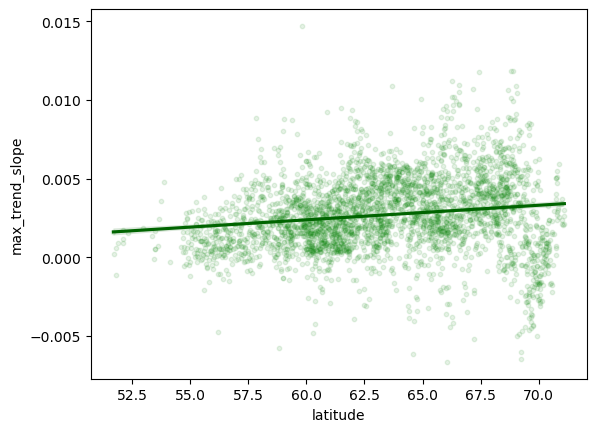

In [111]:
import seaborn as sns
sns.regplot(
    x='latitude',
    y='max_trend_slope',
    data=output,
    scatter_kws={'alpha':0.1,
    's':10},
     line_kws={'color':'darkgreen'},
     color='green'
    )

Ah, a statistically significant greening at higher latitudes in our watersheds!

Can you think of anything else to play with this data? Maybe a spatial join to the permafrost shapefile?

(-180.0, -125.0)

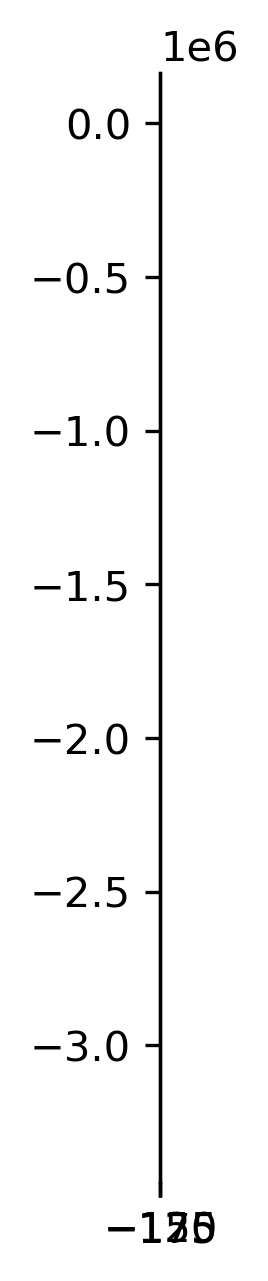

In [112]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(dpi=300)

alaska = permafrost_clipped.plot(column='EXTENT', alpha=0.5, ax=ax)
sheds = output.plot(column='max_trend_slope', cmap='YlGn', ax=ax)

ax.set_xlim(-180,-125)

It's interesting though, on the North Slope (lat>70) there is a browning trend, and that area overlaps with our shrub dominance map...someone could do something with that!